In [1]:
# import tez
import pandas as pd
import tensorflow as tf
import tensorflow_recommenders as tfrs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import model_selection
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


TF_ENABLE_ONEDNN_OPTS = 0

2024-07-29 17:59:05.636293: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-29 17:59:05.837544: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-29 17:59:05.930216: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-29 17:59:05.981487: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-29 17:59:06.104632: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Load the dataset
data = pd.read_csv("data/music_data.csv")
data.head()

,user_id,age,gender,music,artist_name,featured_artists,genre,plays,duration,music_id,...,mode,speechiness,instrumentalness,liveness,valence,tempo,time_signature,explicit,rating,age_group
0,83811,16,F,Bank Account,21 Savage,"Birdy, Zoé",Dark Trap,11,3.67,2fQrGHiQOvpL9UgPvtYy6G,...,0,0.351000,0.000007,0.087100,0.376000,75.016000,4.0,True,1.01,Gen Z
1,83811,16,F,Little Talks,Of Monsters and Men,"Ninho, Snoop Dogg, Russ, Paramore",Unknown,686,4.44,2ihCaVdNZmnHZWt0fvAM7B,...,1,0.032200,0.000000,0.284500,0.413000,101.890500,4.0,False,1.91,Gen Z
2,13397,17,M,Wherever I Go,OneRepublic,"Keith Urban, DJ Khaled, NIKI, MF DOOM",Unknown,136,2.83,46jLy47W8rkf8rEX04gMKB,...,1,0.089400,0.043432,0.273133,0.404183,120.850500,4.0,False,1.18,Gen Z
3,70645,44,M,No New Friends,DJ Khaled,"The xx, LIT killah",Pop,230,5.14,5oVlbbiKGdGeZkWCFy0mqk,...,1,0.167000,0.000000,0.096600,0.400000,109.283000,4.0,False,1.31,Gen X
4,70645,44,M,Dreams,Campsite Dream,NaN,Country,391,3.20,1SNoSoQ3JZldOhzBY9gw0n,...,1,0.078837,0.235527,0.180354,0.380815,120.488479,4.0,False,1.52,Gen X


In [3]:
print(data["rating"].isnull().sum())

0


In [4]:
print(data["rating"].dtype)

float64


In [5]:
scaler = MinMaxScaler(feature_range=(1, 5))
data["rating"] = scaler.fit_transform(data[["plays"]]).round(2)

In [6]:
data.columns

Index(['user_id', 'age', 'gender', 'music', 'artist_name', 'featured_artists',
       'genre', 'plays', 'duration', 'music_id', 'id_artists', 'acousticness',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'explicit', 'rating', 'age_group'],
      dtype='object')

In [7]:
def check_missing_value():
    # show number of missing values as a dataframe by column
    missing_values = data.isnull().sum()
    missing_values = missing_values[missing_values > 0]
    missing_values = missing_values.sort_values(ascending=False)
    missing_values = missing_values.reset_index()
    missing_values.columns = ["Feature", "Missing Values"]
    return missing_values


check_missing_value()

,Feature,Missing Values
0,featured_artists,10356


In [8]:
# Fill featured_artists missing values with "Unknown"
data["featured_artists"].fillna("None", inplace=True)

/tmp/ipykernel_15847/210326270.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["featured_artists"].fillna("None", inplace=True)


In [9]:
check_missing_value()

,Feature,Missing Values


In [10]:
df = data.copy()

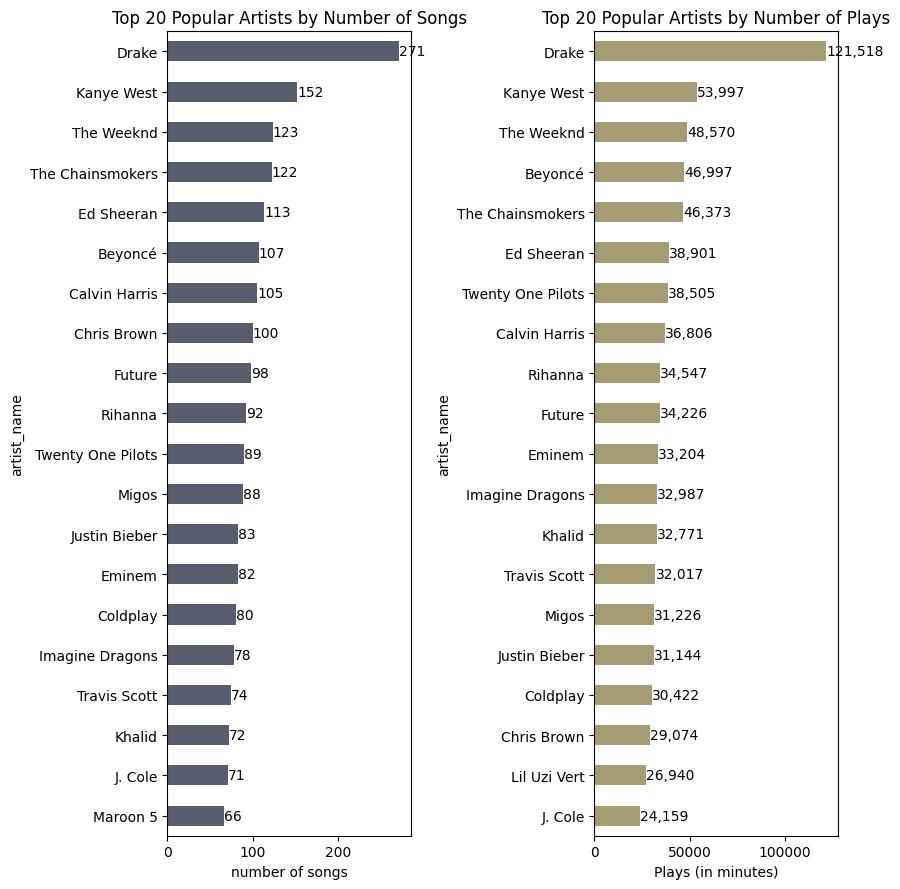

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 9))
TAIL = 20
cc_ = sns.color_palette(n_colors=2, palette="cividis")

df["artist_name"].value_counts().sort_values().tail(TAIL).plot(
    kind="barh", color=cc_[0], ax=ax1
)
ax1.set(
    title=f"Top {TAIL} Popular Artists by Number of Songs", xlabel="number of songs"
)
for container in ax1.containers:
    ax1.bar_label(container, fmt="%.0f")

df.groupby("artist_name")["plays"].sum().sort_values().tail(TAIL).plot(
    kind="barh", color=cc_[1], ax=ax2
)
ax2.set(
    title=f"Top {TAIL} Popular Artists by Number of Plays", xlabel="Plays (in minutes)"
)
for container in ax2.containers:
    ax2.bar_label(container, labels=[f"{int(v):,}" for v in container.datavalues])

plt.tight_layout()  # plots the top 20 popular artists by number of songs and plays

In [12]:
df["duration"]

0        3.67
1        4.44
2        2.83
3        5.14
4        3.20
         ... 
19969    4.03
19970    3.26
19971    4.10
19972    3.93
19973    3.11
Name: duration, Length: 19974, dtype: float64

In [13]:
df["time_signature"]

0        4.0
1        4.0
2        4.0
3        4.0
4        4.0
        ... 
19969    4.0
19970    4.0
19971    4.0
19972    5.0
19973    4.0
Name: time_signature, Length: 19974, dtype: float64

In [14]:
df["key"]

0        8
1        1
2        0
3        1
4        0
        ..
19969    9
19970    9
19971    1
19972    1
19973    8
Name: key, Length: 19974, dtype: int64

In [15]:
df.to_csv("data/music_data.csv", index=False)

## YT Tutorial
---

In [17]:
# df = data.copy()

In [21]:
df.columns

Index(['user_id', 'age', 'gender', 'music', 'artist_name', 'featured_artists',
       'genre', 'plays', 'duration', 'music_id', 'id_artists', 'acousticness',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'explicit', 'rating', 'age_group'],
      dtype='object')

In [16]:
# Feature Engineering
df["song"] = df["music"] + " - " + df["artist_name"]
# df["song"] = df["song"].str.lower()

In [17]:
df["song"].head()

0              Bank Account - 21 Savage
1    Little Talks - Of Monsters and Men
2           Wherever I Go - OneRepublic
3            No New Friends - DJ Khaled
4               Dreams - Campsite Dream
Name: song, dtype: object

In [18]:
check_missing_value()

,Feature,Missing Values


In [19]:
# Popularity based recommendation
# Create a new dataframe with the columns song and rating

In [17]:
# Convert categorical features to string and numerical features to float
data["user_id"] = data["user_id"].astype(str)
data["age"] = data["age"].astype(float)
data["gender"] = data["gender"].astype(str)
data["music_id"] = data["music_id"].astype(str)
data["artist_name"] = data["artist_name"].astype(str)
data["genre"] = data["genre"].astype(str)
data["age_group"] = data["age_group"].astype(str)
data["acousticness"] = data["acousticness"].astype(float)
data["danceability"] = data["danceability"].astype(float)
data["energy"] = data["energy"].astype(float)
data["loudness"] = data["loudness"].astype(float)
data["speechiness"] = data["speechiness"].astype(float)
data["instrumentalness"] = data["instrumentalness"].astype(float)
data["liveness"] = data["liveness"].astype(float)
data["valence"] = data["valence"].astype(float)
data["tempo"] = data["tempo"].astype(float)

# Split the data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)


# Convert pandas DataFrame to tf.data.Dataset
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    df = dataframe.copy()
    labels = df.pop("rating")
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    ds = ds.batch(batch_size)
    return ds


batch_size = 32
train_dataset = df_to_dataset(train_data, batch_size=batch_size)
test_dataset = df_to_dataset(test_data, shuffle=False, batch_size=batch_size)

2024-07-27 07:39:22.000022: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-27 07:39:22.154979: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-27 07:39:22.155032: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-27 07:39:22.157768: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-27 07:39:22.157814: I external/local_xla/xla/stream_executor

In [18]:
class UserModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.user_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.StringLookup(
                    vocabulary=train_data["user_id"].unique(), mask_token=None
                ),
                tf.keras.layers.Embedding(len(train_data["user_id"].unique()) + 1, 64),
            ]
        )
        self.age_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.Normalization(axis=None),
                tf.keras.layers.Dense(8, activation="relu"),
            ]
        )
        self.gender_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.StringLookup(
                    vocabulary=train_data["gender"].unique(), mask_token=None
                ),
                tf.keras.layers.Embedding(len(train_data["gender"].unique()) + 1, 2),
            ]
        )
        self.age_group_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.StringLookup(
                    vocabulary=train_data["age_group"].unique(), mask_token=None
                ),
                tf.keras.layers.Embedding(len(train_data["age_group"].unique()) + 1, 8),
            ]
        )

    def call(self, inputs):
        return tf.concat(
            [
                self.user_embedding(inputs["user_id"]),
                self.age_embedding(tf.reshape(inputs["age"], (-1, 1))),
                self.gender_embedding(inputs["gender"]),
                self.age_group_embedding(inputs["age_group"]),
            ],
            axis=1,
        )


class ItemModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.music_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.StringLookup(
                    vocabulary=train_data["music_id"].unique(), mask_token=None
                ),
                tf.keras.layers.Embedding(len(train_data["music_id"].unique()) + 1, 64),
            ]
        )
        self.artist_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.StringLookup(
                    vocabulary=train_data["artist_name"].unique(), mask_token=None
                ),
                tf.keras.layers.Embedding(
                    len(train_data["artist_name"].unique()) + 1, 64
                ),
            ]
        )
        self.genre_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.StringLookup(
                    vocabulary=train_data["genre"].unique(), mask_token=None
                ),
                tf.keras.layers.Embedding(len(train_data["genre"].unique()) + 1, 16),
            ]
        )
        self.audio_features_embedding = tf.keras.Sequential(
            [tf.keras.layers.Dense(128, activation="relu")]
        )

    def call(self, music_id):
        features = {
            "music_id": music_id,
            "artist_name": train_data.loc[
                train_data["music_id"] == music_id, "artist_name"
            ].iloc[0],
            "genre": train_data.loc[train_data["music_id"] == music_id, "genre"].iloc[
                0
            ],
            "acousticness": train_data.loc[
                train_data["music_id"] == music_id, "acousticness"
            ].iloc[0],
            "danceability": train_data.loc[
                train_data["music_id"] == music_id, "danceability"
            ].iloc[0],
            "energy": train_data.loc[train_data["music_id"] == music_id, "energy"].iloc[
                0
            ],
            "loudness": train_data.loc[
                train_data["music_id"] == music_id, "loudness"
            ].iloc[0],
            "speechiness": train_data.loc[
                train_data["music_id"] == music_id, "speechiness"
            ].iloc[0],
            "instrumentalness": train_data.loc[
                train_data["music_id"] == music_id, "instrumentalness"
            ].iloc[0],
            "liveness": train_data.loc[
                train_data["music_id"] == music_id, "liveness"
            ].iloc[0],
            "valence": train_data.loc[
                train_data["music_id"] == music_id, "valence"
            ].iloc[0],
            "tempo": train_data.loc[train_data["music_id"] == music_id, "tempo"].iloc[
                0
            ],
        }
        return tf.concat(
            [
                self.music_embedding(features["music_id"]),
                self.artist_embedding(features["artist_name"]),
                self.genre_embedding(features["genre"]),
                self.audio_features_embedding(
                    tf.concat(
                        [
                            tf.reshape(features["acousticness"], (-1, 1)),
                            tf.reshape(features["danceability"], (-1, 1)),
                            tf.reshape(features["energy"], (-1, 1)),
                            tf.reshape(features["loudness"], (-1, 1)),
                            tf.reshape(features["speechiness"], (-1, 1)),
                            tf.reshape(features["instrumentalness"], (-1, 1)),
                            tf.reshape(features["liveness"], (-1, 1)),
                            tf.reshape(features["valence"], (-1, 1)),
                            tf.reshape(features["tempo"], (-1, 1)),
                        ],
                        axis=1,
                    )
                ),
            ],
            axis=1,
        )

In [ ]:
class MusicModel(tfrs.models.Model):
    def __init__(self):
        super().__init__()
        self.user_model = UserModel()
        self.item_model = ItemModel()
        candidates = (
            tf.data.Dataset.from_tensor_slices(
                {
                    "music_id": train_data["music_id"].unique(),
                    "artist_name": train_data["artist_name"].unique(),
                    "genre": train_data["genre"].unique(),
                    "acousticness": train_data["acousticness"].unique(),
                    "danceability": train_data["danceability"].unique(),
                    "energy": train_data["energy"].unique(),
                    "loudness": train_data["loudness"].unique(),
                    "speechiness": train_data["speechiness"].unique(),
                    "instrumentalness": train_data["instrumentalness"].unique(),
                    "liveness": train_data["liveness"].unique(),
                    "valence": train_data["valence"].unique(),
                    "tempo": train_data["tempo"].unique(),
                }
            )
            .batch(128)
            .map(lambda x: self.item_model(x))
        )
        self.task = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(candidates=candidates)
        )

    def compute_loss(self, features, training=False):
        user_embeddings = self.user_model(
            {
                "user_id": features["user_id"],
                "age": features["age"],
                "gender": features["gender"],
                "age_group": features["age_group"],
            }
        )
        item_embeddings = self.item_model(features["music_id"])
        return self.task(user_embeddings, item_embeddings)


model = MusicModel()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))
model.fit(train_dataset, epochs=10)

In [47]:
# artist popularity
artist_popularity = (
    data.groupby("artist_name")["plays"].mean().sort_values(ascending=False)
)
artist_popularity = artist_popularity.reset_index()
artist_popularity.columns = ["Artist", "Popularity"]
artist_popularity.head(10)

,Artist,Popularity
0,Mike Zombie,2257.0
1,Craig Armstrong,2185.0
2,The Faint,2018.0
3,Bonnie Hayes With The Wild Combo,2010.0
4,Wee Sing,2007.0
5,Mann,1996.0
6,Yandel,1990.0
7,Vindata,1936.0
8,Little Eva,1930.0
9,Wolfgang Gartner,1907.0


## TFRS docs

In [17]:
from typing import Dict, Text

import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs
from tensorflow.keras.layers import Input, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model

In [18]:
df.columns

Index(['user_id', 'age', 'gender', 'music', 'artist_name', 'featured_artists',
       'genre', 'plays', 'duration', 'music_id', 'id_artists', 'acousticness',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'explicit', 'rating', 'age_group'],
      dtype='object')

In [19]:
# from unicodedata import numeric


features = df.columns.tolist()
features.remove("plays")

categorical_features = df.select_dtypes(include=[object]).columns.tolist()
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()

In [20]:
categorical_features

['gender',
 'music',
 'artist_name',
 'featured_artists',
 'genre',
 'music_id',
 'id_artists',
 'age_group']

In [24]:
# categorical_features.remove(["music", "artist_name", "featured_artists", "song"])

In [26]:
categorical_features = df.select_dtypes(include=[object]).columns.tolist()
# categorical_features.remove("song")
categorical_features.append("explicit")
categorical_features

['gender',
 'music',
 'artist_name',
 'featured_artists',
 'genre',
 'music_id',
 'id_artists',
 'age_group',
 'explicit']

In [28]:
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
# numeric_features.remove("plays_log")
numeric_features

['user_id',
 'age',
 'plays',
 'duration',
 'acousticness',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'time_signature',
 'rating']

In [29]:
# Preprocess categorical features
vocabularies = {}

embedding_dim = 64  # Adjust embedding dimension as needed

# Create embedding layers
embedding_layers = {}
for feature in categorical_features:
    vocab_size = len(df[feature].unique())
    embedding_layers[feature] = Embedding(
        input_dim=vocab_size, output_dim=embedding_dim
    )

# Preprocess numerical features (normalization or standardization might be needed)
numeric_inputs = {}
for feature in numeric_features:
    numeric_inputs[feature] = tf.keras.layers.Input(shape=(1,), dtype=tf.float32)

# Create a TensorFlow Dataset
dataset = tf.data.Dataset.from_tensor_slices(dict(df))

I0000 00:00:1722276402.900075   15847 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722276403.258030   15847 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722276403.258110   15847 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722276403.263723   15847 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1722276403.263907   15847 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [30]:
# set seed for reproducibility
tf.random.set_seed(42)

# Shuffle the dataset with a buffer size of 1000
shuffled_dataset = dataset.shuffle(
    buffer_size=1000, seed=42, reshuffle_each_iteration=False
)

# Split the shuffled dataset (adjust the split ratio as needed)
train_size = int(0.8 * len(shuffled_dataset))
train_dataset = shuffled_dataset.take(train_size)
test_dataset = shuffled_dataset.skip(train_size)

In [32]:
# select an entry in the train dataset
import pprint


for x in train_dataset.take(1).as_numpy_iterator():
    pprint.pprint(x)

{'acousticness': 0.079375,
 'age': 17,
 'age_group': b'Gen Z',
 'artist_name': b'Turnpike Troubadours',
 'danceability': 0.58875,
 'duration': 3.77,
 'energy': 0.776,
 'explicit': False,
 'featured_artists': b'None',
 'gender': b'F',
 'genre': b'Dance/Electronic',
 'id_artists': b'spotify:artist:1YSA4byX5AL1zoTsSTlB03',
 'instrumentalness': 0.0109060224999999,
 'key': 2,
 'liveness': 0.0906,
 'loudness': -6.033250000000001,
 'mode': 1,
 'music': b'Every Girl',
 'music_id': b'3l4cnZdtNbVZgV3ICYh1Ni',
 'plays': 441,
 'rating': 1.59,
 'speechiness': 0.0318499999999999,
 'tempo': 134.50725,
 'time_signature': 4.0,
 'user_id': 6372,
 'valence': 0.5832499999999999}


2024-07-29 18:07:08.149852: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [93]:
features

['user_id',
 'gender',
 'music',
 'artist_name',
 'featured_artists',
 'genre',
 'music_id',
 'id_artists',
 'age_group',
 'age',
 'plays',
 'duration',
 'acousticness',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'time_signature',
 'rating',
 'popularity_score']

In [104]:
# # Define categorical and numerical features
# from sklearn.preprocessing import MinMaxScaler
# import tensorflow as tf
# from tensorflow.keras.layers import Embedding

# # Define categorical and numerical features
# # categorical_features = df.select_dtypes(include=[object]).columns.tolist()
# # numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()


# # Preprocess categorical features with StringLookup
# vocabularies = {}

# embedding_dim = 64  # Adjust embedding dimension as needed

# # Create embedding layers
# embedding_layers = {}
# for feature in categorical_features:
#   vocab_size = len(df[feature].unique())
#   embedding_layers[feature] = Embedding(input_dim=vocab_size, output_dim=embedding_dim)

# # Preprocess numerical features (normalization or standardization might be needed)
# numeric_inputs = {}
# for feature in numeric_features:
#     scaler = MinMaxScaler()
#     df[feature] = scaler.fit_transform(df[[feature]])  # Standardize based on your data
#     numeric_inputs[feature] = tf.keras.layers.Input(shape=(1,), dtype=tf.float32)

# def feature_map(data):
#   categorical_features_map = {}
#   for feature in categorical_features:
#     categorical_features_map[feature] = vocabularies[feature](data[feature])  # Use integer indices
#   numeric_features_map = {feature: data[feature] for feature in numeric_features}
#   return {**categorical_features_map, **numeric_features_map}


# # Create a TensorFlow Dataset
# dataset = tf.data.Dataset.from_tensor_slices(df.map(feature_map))

# # Set seed for reproducibility
# tf.random.set_seed(42)

# # Shuffle the dataset with a buffer size of 1000
# shuffled_dataset = dataset.shuffle(
#     buffer_size=1000, seed=42, reshuffle_each_iteration=True
# )

# # Split the shuffled dataset (adjust the split ratio as needed)
# train_size = int(0.8 * len(shuffled_dataset))
# train_dataset, test_dataset = shuffled_dataset.split(train_size)

In [ ]:
import tensorflow as tf
import pandas as pd


def create_tf_dataset(df):
    def generate_data():
        for _, row in df.iterrows():
            yield (
                {
                    "user_id": row["user_id"],
                    "music_id": row["music_id"],
                    "genre": row["genre"],
                    "artist": row["artist"],
                    "age": row["age"],
                    # ... other features
                },
                row["plays"],
            )

    dataset = tf.data.Dataset.from_generator(
        generate_data,
        output_signature=(
            {
                "user_id": tf.int32,
                "music_id": tf.int32,
                "genre": tf.string,  # Adjust based on genre encoding
                "artist": tf.string,  # Adjust based on artist encoding
                "age": tf.float32,
                # ... other features
            },
            tf.float32,
        ),
    )
    return dataset


train_dataset = create_tf_dataset(train_df)
val_dataset = create_tf_dataset(val_df)

In [105]:
# features = categorical_features + numeric_features
# features

In [81]:
# Create tensorflow datasets

import tensorflow as tf
import pandas as pd


def create_tf_dataset(df):
    def generate_data():
        for _, row in df.iterrows():
            yield (
                {
                    "user_id": row["user_id"],
                    "music_id": row["music_id"],
                    "gender": row["gender"],
                    "age_group": row["age_group"],
                    "id_artists": row["id_artists"],
                    "popularity_score": row["popularity_score"],
                    "genre": row["genre"],
                    "artist_name": row["artist_name"],
                    "age": row["age"],
                    "featured_artists": row["featured_artists"],
                    "music": row["music"],
                    "plays": row["plays"],
                    "duration": row["duration"],
                    "time_signature": row["time_signature"],
                    "key": row["key"],
                    "explicit": row["explicit"],
                    "mode": row["mode"],
                    "rating": row["rating"],
                    "acousticness": row["acousticness"],
                    "danceability": row["danceability"],
                    "energy": row["energy"],
                    "loudness": row["loudness"],
                    "speechiness": row["speechiness"],
                    "instrumentalness": row["instrumentalness"],
                    "liveness": row["liveness"],
                    "valence": row["valence"],
                    "tempo": row["tempo"],
                },
            )

    dataset = tf.data.Dataset.from_generator(
        generate_data,
        output_signature=(
            {
                "user_id": tf.int32,
                "music_id": tf.int32,
                "genre": tf.string,  # Adjust based on genre encoding
                "artist_name": tf.string,  # Adjust based on artist encoding
                "age": tf.float32,
                "gender": tf.string,
                "music": tf.string,
                "artist_name": tf.string,
                "featured_artists": tf.string,
                "id_artists": tf.string,
                "age_group": tf.string,
                "plays": tf.int32,
                "duration": tf.int32,
                "explicit": tf.string,
                "acousticness": tf.int32,
                "danceability": tf.int32,
                "energy": tf.int32,
                "key": tf.int32,
                "loudness": tf.int32,
                "mode": tf.int32,
                "speechiness": tf.int32,
                "instrumentalness": tf.int32,
                "liveness": tf.int32,
                "valence": tf.int32,
                "tempo": tf.int32,
                "time_signature": tf.int32,
                "rating": tf.int32,
                "popularity_score": tf.int32,
            }
        ),
    )
    return dataset


# train_dataset = create_tf_dataset(train_df)
# val_dataset = create_tf_dataset(val_df)

In [119]:
# Define input layers for categorical features
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout

categorical_inputs = {}
for feature in categorical_features:
    categorical_inputs[feature] = Input(shape=(1,), dtype=tf.int32, name=feature)

# Reshape numerical features to have an extra dimension of size 1
for feature, input_layer in numeric_inputs.items():
    numeric_inputs[feature] = tf.keras.layers.Reshape(target_shape=(1, 1))(input_layer)

# Concatenate all embeddings and numerical inputs
embeddings_list = [
    embedding_layers[feature](categorical_input)
    for feature, categorical_input in categorical_inputs.items()
]
all_inputs = embeddings_list + list(numeric_inputs.values())
concatenated = Concatenate()(all_inputs)

# Add hidden layers
x = Dense(256, activation="relu", kernel_regularizer=l2(0.01))(concatenated)
x = Dropout(0.2)(x)
x = Dense(128, activation="relu", kernel_regularizer=l2(0.01))(x)

# Output layer
output = Dense(1, activation="sigmoid")(x)

model = Model(
    inputs=list(categorical_inputs.values()) + list(numeric_inputs.values()),
    outputs=output,
)

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(train_dataset, validation_data=test_dataset, epochs=10)

Epoch 1/10


ValueError: in user code:

    File "/home/jnopareboateng/anaconda3/envs/venv_310/lib/python3.10/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/home/jnopareboateng/anaconda3/envs/venv_310/lib/python3.10/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jnopareboateng/anaconda3/envs/venv_310/lib/python3.10/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/home/jnopareboateng/anaconda3/envs/venv_310/lib/python3.10/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/home/jnopareboateng/anaconda3/envs/venv_310/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/jnopareboateng/anaconda3/envs/venv_310/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 197, in assert_input_compatibility
        raise ValueError(

    ValueError: Missing data for input "input_227". You passed a data dictionary with keys ['user_id', 'age', 'gender', 'music', 'artist_name', 'featured_artists', 'genre', 'plays', 'duration', 'music_id', 'id_artists', 'acousticness', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'explicit', 'rating', 'age_group', 'song', 'plays_log', 'popularity_score', 'input_210', 'input_211', 'input_212', 'input_213', 'input_214', 'input_215', 'input_216', 'input_217', 'input_218', 'input_219', 'input_220', 'input_221', 'input_222', 'input_223', 'input_224', 'input_225', 'input_226']. Expected the following keys: ['user_id', 'gender', 'music', 'artist_name', 'featured_artists', 'genre', 'music_id', 'id_artists', 'age_group', 'explicit', 'input_227', 'input_228', 'input_229', 'input_230', 'input_231', 'input_232', 'input_233', 'input_234', 'input_235', 'input_236', 'input_237', 'input_238', 'input_239', 'input_240', 'input_241', 'input_242', 'input_243']


## Test 2

In [33]:
df.columns

Index(['user_id', 'age', 'gender', 'music', 'artist_name', 'featured_artists',
       'genre', 'plays', 'duration', 'music_id', 'id_artists', 'acousticness',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'explicit', 'rating', 'age_group'],
      dtype='object')

In [34]:
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19974 entries, 0 to 19973
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           19974 non-null  int64  
 1   age               19974 non-null  int64  
 2   gender            19974 non-null  object 
 3   music             19974 non-null  object 
 4   artist_name       19974 non-null  object 
 5   featured_artists  19974 non-null  object 
 6   genre             19974 non-null  object 
 7   plays             19974 non-null  int64  
 8   duration          19974 non-null  float64
 9   music_id          19974 non-null  object 
 10  id_artists        19974 non-null  object 
 11  acousticness      19974 non-null  float64
 12  danceability      19974 non-null  float64
 13  energy            19974 non-null  float64
 14  key               19974 non-null  int64  
 15  loudness          19974 non-null  float64
 16  mode              19974 non-null  int64 

In [35]:
# Ensure all columns have consistent df types
df["user_id"] = df["user_id"].astype(str)
df["music_id"] = df["music_id"].astype(str)
df["music"] = df["music"].astype(str)
df["age"] = df["age"].astype(int)
df["gender"] = df["gender"].astype(str)
df["age_group"] = df["age_group"].astype(str)
df["plays"] = df["plays"].astype(int)
df["duration"] = df["duration"].astype(float)
df["acousticness"] = df["acousticness"].astype(float)
df["danceability"] = df["danceability"].astype(float)
df["energy"] = df["energy"].astype(float)
df["key"] = df["key"].astype(int)
df["loudness"] = df["loudness"].astype(float)
df["mode"] = df["mode"].astype(int)
df["speechiness"] = df["speechiness"].astype(float)
df["instrumentalness"] = df["instrumentalness"].astype(float)
df["liveness"] = df["liveness"].astype(float)
df["valence"] = df["valence"].astype(float)
df["tempo"] = df["tempo"].astype(float)
df["time_signature"] = df["time_signature"].astype(float)
df["explicit"] = df["explicit"].astype(bool)
df["rating"] = df["rating"].astype(float)
# df["release_year"] = df["release_year"].astype(int)
# df['release_year'] = df['release_year'].astype(int)

In [36]:
import tensorflow as tf
import tensorflow_recommenders as tfrs
import pandas as pd

# df


def df_to_dataset(dataframe, shuffle=True, batch_size=64):
    dataframe = dataframe.copy()
    # labels = dataframe.pop('target').astype('float64')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe)))
    # if shuffle:
    # ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds


# Convert DataFrame to TensorFlow dataset
dataset = df_to_dataset(df, batch_size=64)

# Set seed for reproducibility
tf.random.set_seed(42)

dataset_size = tf.data.experimental.cardinality(dataset)
print(f"Estimated dataset size: {dataset_size.numpy()}")


# Shuffle the dataset with a buffer size of 1000
shuffled_dataset = dataset.shuffle(
    buffer_size=len(df), seed=42, reshuffle_each_iteration=False
)

# Split the shuffled dataset (adjust the split ratio as needed)
train_size = int(0.8 * len(df))
train_dataset = shuffled_dataset.take(train_size)
test_dataset = shuffled_dataset.skip(train_size)
print(
    f"Estimated train size: {train_size}\nEstimated test dataset size: {len(df) - train_size}"
)

# # Print dataset shapes for debugging
# print("Train dataset shapes:")
# for batch in cached_train.take(10):
#   for key, value in batch.items():
#     print(f"{key}: {tf.shape(value)}")

# print("Test dataset shapes:")
# for batch in cached_test.take(10):
#   for key, value in batch.items():
#     print(f"{key}: {tf.shape(value)}")

Estimated dataset size: 313
Estimated train size: 15979
Estimated test dataset size: 3995


In [37]:
# Define embedding dimensions
embedding_dimension = 128
# Extract unique values for lookup layers and ensure no duplicates
unique_user_ids = df["user_id"].astype(str).unique().tolist()
unique_ages = df["age"].unique().tolist()
unique_genders = df["gender"].unique().tolist()
unique_song_ids = df["music_id"].unique().tolist()
unique_music = df["music"].unique().tolist()
unique_genres = df["genre"].unique().tolist()
unique_artist_names = df["artist_name"].unique().tolist()
# unique_featured_artists = (df["featured_artists"].unique().tolist())
unique_age_groups = df["age_group"].unique().tolist()


# Define user model
class UserModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.user_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.StringLookup(
                    vocabulary=unique_user_ids, mask_token=None
                ),
                tf.keras.layers.Embedding(
                    len(unique_user_ids) + 1, embedding_dimension
                ),
            ]
        )
        self.age_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.IntegerLookup(vocabulary=unique_ages, mask_token=None),
                tf.keras.layers.Embedding(len(unique_ages) + 1, embedding_dimension),
            ]
        )
        self.gender_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.StringLookup(
                    vocabulary=unique_genders, mask_token=None
                ),
                tf.keras.layers.Embedding(len(unique_genders) + 1, embedding_dimension),
            ]
        )
        self.age_group_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.StringLookup(
                    vocabulary=unique_age_groups, mask_token=None
                ),
                tf.keras.layers.Embedding(
                    len(unique_age_groups) + 1, embedding_dimension
                ),
            ]
        )

    def call(self, inputs):
        return tf.concat(
            [
                self.user_embedding(inputs["user_id"]),
                self.age_embedding(inputs["age"]),
                self.gender_embedding(inputs["gender"]),
                self.age_group_embedding(inputs["age_group"]),
            ],
            axis=1,
        )


# Define item model with audio features
class ItemModel(tf.keras.Model):

    def __init__(self):
        super().__init__()
        self.song_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.StringLookup(vocabulary=unique_music, mask_token=None),
                tf.keras.layers.Embedding(len(unique_music) + 1, embedding_dimension),
            ]
        )
        self.genre_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.StringLookup(vocabulary=unique_genres, mask_token=None),
                tf.keras.layers.Embedding(len(unique_genres) + 1, embedding_dimension),
            ]
        )

        self.artist_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.StringLookup(
                    vocabulary=unique_artist_names, mask_token=None
                ),
                tf.keras.layers.Embedding(
                    len(unique_artist_names) + 1, embedding_dimension
                ),
            ]
        )
        # self.featured_artists_embedding = tf.keras.Sequential(
        #     [
        #         tf.keras.layers.StringLookup(
        #             vocabulary=unique_featured_artists, mask_token=None
        #         ),
        #         tf.keras.layers.Embedding(
        #             len(unique_featured_artists) + 1, embedding_dimension
        #         ),
        #     ]
        # )

        self.audio_features = tf.keras.layers.Dense(embedding_dimension)

    def call(self, inputs):

        # Reshape all embeddings to have the same embedding dimension
        song_embedding = self.song_embedding(
            inputs["music"],
        )
        # song_embedding = tf.reshape(song_embedding, [-1, embedding_dimension])
        genre_embedding = self.genre_embedding(inputs["genre"])
        # genre_embedding = tf.reshape(genre_embedding, [-1, embedding_dimension])
        artist_embedding = self.artist_embedding(inputs["artist_name"])
        # artist_embedding = tf.reshape(artist_embedding, [-1, embedding_dimension])
        # featured_artists_embedding = self.featured_artists_embedding(
        #     inputs["featured_artists"]
        # )
        # featured_artists_embedding = tf.reshape(
        #     featured_artists_embedding, [-1, embedding_dimension]
        # )

        audio_features = tf.stack(
            [
                tf.cast(inputs["acousticness"], tf.float32),
                tf.cast(inputs["danceability"], tf.float32),
                tf.cast(inputs["energy"], tf.float32),
                tf.cast(inputs["key"], tf.float32),
                tf.cast(inputs["loudness"], tf.float32),
                tf.cast(inputs["mode"], tf.float32),
                tf.cast(inputs["speechiness"], tf.float32),
                tf.cast(inputs["instrumentalness"], tf.float32),
                tf.cast(inputs["liveness"], tf.float32),
                tf.cast(inputs["valence"], tf.float32),
                tf.cast(inputs["tempo"], tf.float32),
                tf.cast(inputs["time_signature"], tf.float32),
            ],
            axis=1,
        )
        audio_features = self.audio_features(audio_features)
        # audio_features = tf.reshape(audio_features, [-1, embedding_dimension])

        return tf.concat(
            [
                song_embedding,
                genre_embedding,
                artist_embedding,
                # featured_artists_embedding,
                audio_features,
            ],
            axis=1,
        )


#
# Define the hybrid model
class HybridModel(tfrs.models.Model):

    def __init__(self, user_model, item_model):
        super().__init__()
        self.user_model = user_model
        self.item_model = item_model
        self.shuffled_dataset = shuffled_dataset
        self.task = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=shuffled_dataset.map(lambda x: x["music"])
            )
        )

    def compute_loss(self, features, training=False):

        user_embeddings = self.user_model(features)
        item_embeddings = self.item_model(features)
        weights = features["plays"]
        return self.task(user_embeddings, item_embeddings, sample_weight=weights)


# Instantiate models
user_model = UserModel()
item_model = ItemModel()
model = HybridModel(user_model, item_model)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))


# Instantiate models
batch_size = 1024  # Start with 1024, adjust if needed

cached_train = (
    train_dataset.batch(batch_size, drop_remainder=True)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)
cached_test = test_dataset.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

# Print dataset shapes for debugging
print("Train dataset shapes:")
for batch in cached_train.take(1):
    for key, value in batch.items():
        print(f"{key}: {tf.shape(value)}")

print("Test dataset shapes:")
for batch in cached_test.take(1):
    for key, value in batch.items():
        print(f"{key}: {tf.shape(value)}")

# Fit the model
try:
    model.fit(cached_train, epochs=10)
except Exception as e:
    print(f"Error during model fitting: {e}")

# Evaluate the model
try:
    model.evaluate(cached_test, return_dict=True)
except Exception as e:
    print(f"Error during model evaluation: {e}")

ValueError: Cannot convert '('c', 'o', 'u', 'n', 't', 'e', 'r')' to a shape. Found invalid entry 'c' of type '<class 'str'>'. 

In [86]:
# Take the first N elements
import pprint


first_n_elements = train_dataset.take(1)

# Iterate over the elements and print
for element in first_n_elements:
    pprint.pprint(element)

{'acousticness': <tf.Tensor: shape=(64,), dtype=float64, numpy=
array([1.79917750e-01, 2.14000000e-01, 4.85413171e-01, 2.10000000e-01,
       5.42335905e-01, 3.04866667e-01, 6.60000000e-01, 2.70506000e-01,
       2.11000000e-01, 1.80513533e-01, 6.10000000e-02, 3.77848500e-01,
       3.33986465e-01, 5.50500000e-01, 1.16000000e-01, 2.99610690e-01,
       4.20700000e-01, 6.81000000e-01, 1.93566667e-01, 2.77236683e-01,
       1.48130000e-01, 1.47100000e-01, 5.47375000e-01, 1.33466667e-01,
       2.61000000e-01, 1.21545800e-01, 3.61666667e-01, 2.17000000e-05,
       7.69000000e-01, 2.37000000e-03, 4.22000000e-05, 2.50000000e-01,
       2.98078852e-01, 1.70197501e-01, 3.39550000e-01, 3.70810000e-01,
       9.89333333e-01, 1.03000000e-02, 3.62076429e-01, 2.54449167e-01,
       4.93750516e-01, 3.41641864e-01, 3.87500000e-02, 1.68500000e-01,
       1.11202250e-01, 5.44120000e-01, 4.29380000e-01, 3.59084232e-01,
       9.13000000e-02, 4.60107875e-01, 8.32000000e-01, 5.41000000e-02,
       2.8405

In [39]:
import tensorflow as tf
import tensorflow_recommenders as tfrs

# Define embedding dimensions
embedding_dimension = 128

# Extract unique values for lookup layers and ensure no duplicates
unique_user_ids = df["user_id"].astype(str).unique().tolist()
unique_ages = df["age"].unique().tolist()
unique_genders = df["gender"].unique().tolist()
unique_song_ids = df["music_id"].unique().tolist()
unique_genres = df["genre"].unique().tolist()
unique_artist_names = df["artist_name"].unique().tolist()
unique_age_groups = df["age_group"].unique().tolist()


# Define user model
class UserModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.user_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.StringLookup(
                    vocabulary=unique_user_ids, mask_token=None
                ),
                tf.keras.layers.Embedding(
                    len(unique_user_ids) + 1, embedding_dimension
                ),
            ]
        )
        self.age_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.IntegerLookup(vocabulary=unique_ages, mask_token=None),
                tf.keras.layers.Embedding(len(unique_ages) + 1, embedding_dimension),
            ]
        )
        self.gender_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.StringLookup(
                    vocabulary=unique_genders, mask_token=None
                ),
                tf.keras.layers.Embedding(len(unique_genders) + 1, embedding_dimension),
            ]
        )
        self.age_group_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.StringLookup(
                    vocabulary=unique_age_groups, mask_token=None
                ),
                tf.keras.layers.Embedding(
                    len(unique_age_groups) + 1, embedding_dimension
                ),
            ]
        )

    def call(self, inputs):
        return tf.concat(
            [
                self.user_embedding(inputs["user_id"]),
                self.age_embedding(inputs["age"]),
                self.gender_embedding(inputs["gender"]),
                self.age_group_embedding(inputs["age_group"]),
            ],
            axis=1,
        )


# Define item model with audio features
class ItemModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.song_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.StringLookup(
                    vocabulary=unique_song_ids, mask_token=None
                ),
                tf.keras.layers.Embedding(
                    len(unique_song_ids) + 1, embedding_dimension
                ),
            ]
        )
        self.genre_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.StringLookup(vocabulary=unique_genres, mask_token=None),
                tf.keras.layers.Embedding(len(unique_genres) + 1, embedding_dimension),
            ]
        )
        self.artist_embedding = tf.keras.Sequential(
            [
                tf.keras.layers.StringLookup(
                    vocabulary=unique_artist_names, mask_token=None
                ),
                tf.keras.layers.Embedding(
                    len(unique_artist_names) + 1, embedding_dimension
                ),
            ]
        )
        self.audio_features = tf.keras.layers.Dense(embedding_dimension)

    def call(self, inputs):
        song_embedding = self.song_embedding(inputs["music"])
        genre_embedding = self.genre_embedding(inputs["genre"])
        artist_embedding = self.artist_embedding(inputs["artist_name"])

        # Check shape of audio features
        audio_features = tf.stack(
            [
                inputs["acousticness"],
                inputs["danceability"],
                inputs["energy"],
                inputs["key"],
                inputs["loudness"],
                inputs["mode"],
                inputs["speechiness"],
                inputs["instrumentalness"],
                inputs["liveness"],
                inputs["valence"],
                inputs["tempo"],
                inputs["time_signature"],
            ],
            axis=1,
        )

        # Print shapes for debugging
        print(f"Audio features shape before Dense layer: {audio_features.shape}")

        audio_features = self.audio_features(audio_features)

        return tf.concat(
            [song_embedding, genre_embedding, artist_embedding, audio_features], axis=1
        )


# Define the hybrid model
class HybridModel(tfrs.models.Model):
    def __init__(self, user_model, item_model, candidates):
        super().__init__()
        self.user_model = user_model
        self.item_model = item_model
        self.task = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(candidates=candidates)
        )
        

    def compute_loss(self, features, training=False):
        user_embeddings = self.user_model(features)
        item_embeddings = self.item_model(features)
        # weights = features.get(
        #     "plays", None
        # )  # Handle cases where 'plays' might not be present
        return self.task(user_embeddings, item_embeddings)


# Check if candidates are not empty
candidates = train_dataset.map(lambda x: x["music"])
for candidate in candidates.take(1):
    print(f"Candidate sample: {candidate.numpy()}")

# Ensure candidates are correctly mapped
if not list(candidates):
    raise ValueError(
        "Candidates set is empty. Ensure 'music_id' is correctly mapped from the dataset."
    )

# Instantiate models
user_model = UserModel()
item_model = ItemModel()
model = HybridModel(user_model, item_model, candidates)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

# Cache datasets for performance
batch_size = 64  # Adjust as needed

cached_train = train_dataset.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
cached_test = test_dataset.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

# Print dataset shapes for debugging
print("Train dataset shapes:")
for batch in cached_train.take(1):
    for key, value in batch.items():
        print(f"{key}: {tf.shape(value)}")

print("Test dataset shapes:")
for batch in cached_test.take(1):
    for key, value in batch.items():
        print(f"{key}: {tf.shape(value)}")

# Fit the model
try:
    model.fit(cached_train, epochs=10)
except Exception as e:
    print(f"Error during model fitting: {e}")

# Evaluate the model
try:
    model.evaluate(cached_test, return_dict=True)
except Exception as e:
    print(f"Error during model evaluation: {e}")

Candidate sample: [b'Tequila' b'Altes Kamuffel' b'Wish You Were Here' b'A-Punk' b'Morning'
 b'Homegrown' b'Take Me To Church' b'99 Red Balloons'
 b'Young Dumb & Broke' b'Attention' b'1991' b'Evermore' b'Wait'
 b'How Deep Is Your Love' b'Sex Me (Part I) / Sex Me (Part II)' b'Shining'
 b'Mad' b"I'm Into You" b'Holy Grail' b'Jesus Saves' b'Aloha' b'Party Up'
 b'Cecilia' b'Timber' b'Way Down We Go' b'Free to Be Me' b'Like A Virgin'
 b'POWER' b'Poison & Wine' b'505' b'Yuba Diamond'
 b'Para Sempre (feat. Elin Melgarejo)' b'Limbo' b'Notice' b'Irreplaceable'
 b'B.Y.O.B.' b'Whispers In The Dark' b'Goodies' b'Evil Woman' b'Domino'
 b'Awakening' b'Annie' b'Bulls On Parade' b"She's so High" b'Salute'
 b'Bottoms Up' b'Teenage Dream' b'Landslide' b'Hello, My Name Is'
 b'As You Are' b'I Want a Hippopotamus for Christmas (Hippo the Hero)'
 b'Money Longer' b"Ain't Your Mama" b'Spiderwebs' b'Sorry' b'Firework'
 b'Mi Primer Amor' b'My Love (feat. Major Lazer, WizKid, Dua Lipa)'
 b'I Wanna Dance with Some

2024-07-29 18:15:57.349940: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


ValueError: Cannot convert '('c', 'o', 'u', 'n', 't', 'e', 'r')' to a shape. Found invalid entry 'c' of type '<class 'str'>'. 